In [1]:

from grid2op.Agent import RandomAgent
from grid2op.Converter.IdToAct import IdToAct

from grid2op import make
from grid2op.Action.PlayableAction import PlayableAction
from grid2op.Parameters import Parameters
from grid2op.multi_agent.multiAgentEnv import MultiAgentEnv
import re
import numpy as np
from grid2op.multi_agent.multi_agentExceptions import *

from lightsim2grid import LightSimBackend
bk_cls = LightSimBackend
    
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

from grid2op.PlotGrid import PlotMatplot


action_domains = {
    'agent_0' : [0,1,2,3, 4],
    'agent_1' : [5,6,7,8,9,10,11,12,13]
}
        

In [2]:
from typing import Dict
from grid2op.multi_agent.ma_typing import MAAgents
from grid2op.Environment.BaseEnv import BaseEnv
from grid2op.Agent.baseAgent import BaseAgent
from grid2op.multi_agent.multiAgentEnv import MultiAgentEnv


def _run_simple_actor(
    env : BaseEnv,
    actor : BaseAgent,
    nb_episodes : int,
) -> dict:
    
    T = np.zeros(nb_episodes, dtype = int)
    obs = env.reset()
    t = 0
    
    rewards_history = []
    mean_rewards_history = np.zeros(nb_episodes)
    std_rewards_history = np.zeros(nb_episodes)
    cumulative_reward = np.zeros(nb_episodes)
    
    info_history = [[] for _ in range(nb_episodes)]
    
    obs_history = [[] for _ in range(nb_episodes)]
    
    done_history = [[] for _ in range(nb_episodes)]
    
    actions_history = [[] for _ in range(nb_episodes)]
    
    reward = 0
    
    for episode in range(nb_episodes):
        while True:
            t += 1
            action = actor.act(observation = obs, reward = reward)
            obs, reward, done, info = env.step(action)

            rewards_history.append(reward)
            info_history[episode].append(info.copy())
            obs_history[episode].append(obs.copy())
            done_history[episode].append(done)
            actions_history[episode].append(action.copy())
            

            if done:
                mean_rewards_history[episode] = np.mean(rewards_history)
                std_rewards_history[episode] = np.std(rewards_history)
                cumulative_reward[episode] = np.sum(rewards_history)
                obs = env.reset()
                T[episode] = t
                t = 0
                break
            
    return {
        'mean_rewards' : mean_rewards_history,
        'std_rewards' : std_rewards_history,
        'episode_len' : T,
        'info_history' : info_history,
        'obs_history' : obs_history,
        'done_history' : done_history,
        'actions' : actions_history,
        'cumulative_reward' : cumulative_reward
         
        # TODO cum reward done
        # TODO local actions
    }

def _run_ma_actors(
    ma_env : MultiAgentEnv,
    actors : MAAgents,
    nb_episodes : int,
) -> dict:
    
    T = np.zeros(nb_episodes, dtype = int)
    obs = ma_env.reset()
    t = 0
    
    rewards_history = []
    mean_rewards_history = np.zeros(nb_episodes)
    std_rewards_history = np.zeros(nb_episodes)
    cumulative_reward = np.zeros(nb_episodes)
    
    info_history = [[] for _ in range(nb_episodes)]
    
    #obs_history = [[] for _ in range(nb_episodes)]
    
    done_history = [[] for _ in range(nb_episodes)]
    
    actions_history = [[] for _ in range(nb_episodes)]
    
    r = 0
    
    for episode in range(nb_episodes):
        while True:
            t += 1
            actions = {
                agent : actors[agent].act(observation = obs[agent], reward = r)
                for agent in ma_env.agents
            }
            obs, reward, dones, info = ma_env.step(actions)

            r = reward[ma_env.agents[0]]
            rewards_history.append(r)
            info_history[episode].append(info[ma_env.agents[0]].copy())
            #obs_history[episode].append(obs[ma_env.agents[0]].copy())
            done_history[episode].append(dones[ma_env.agents[0]])
            actions_history[episode].append(ma_env.global_action.copy())
                

            if dones[ma_env.agents[0]]:
                mean_rewards_history[episode] = np.mean(rewards_history)
                std_rewards_history[episode] =  np.std(rewards_history)
                cumulative_reward[episode] = np.sum(rewards_history)
                
                obs = ma_env.reset()
                T[episode] = t
                t = 0
                break
            
    return {
        'mean_rewards' : mean_rewards_history,
        'std_rewards' : std_rewards_history,
        'episode_len' : T,
        'info_history' : info_history,
        #'obs_history' : obs_history,
        'done_history' : done_history,
        'actions' : actions_history,
        'cumulative_reward' : cumulative_reward
    }

    
def compare_simple_and_multi(
    ma_env : BaseEnv, # It is grid2op.multi_agent.multiAgentEnv.MultiAgentEnv
    simple_actor : BaseAgent, 
    ma_actors : MAAgents, 
    episodes : int = 2,
    seed = 0,
    chronics_id = 0,
    save_path = "./"
    ):
    
    #ma_env = MultiAgentEnv(env, action_domains, copy_env=False)
    
    ma_env.seed(seed)
    ma_env._cent_env.set_id(chronics_id)
    
    results_simple = _run_simple_actor(ma_env._cent_env, simple_actor, episodes)
    results_ma = _run_ma_actors(ma_env, ma_actors, episodes)
    
    #save results
    # TODO
    
    return results_simple, results_ma

In [3]:
from grid2op.multi_agent.ma_typing import LocalObservation
from grid2op.Agent import BaseAgent

class DisconnectorLocalObs(BaseAgent):
    def __init__(self,
                 action_space,
                 is_local = False,
                 threshold_powerFlow_safe = 1.,
                 **kwargs):
        super().__init__(action_space)
        self.lines_disconnected = set()
        self.action_space = action_space
        self.threshold_powerFlow_safe = threshold_powerFlow_safe
        self.is_local = is_local

        
    def act(self, observation : LocalObservation, reward, done = False):

        # Look for overloads and rank them
        #ltc_list = self.getRankedOverloads(observation)
        #counterTestedOverloads = 0
        overloaded = (observation.rho >= self.threshold_powerFlow_safe)
        
        if not np.any(overloaded):
            return self.action_space({})
        else:
            action = self.action_space({})
            
            overloaded_lines = np.where(overloaded)[0]
            
            for lineid in overloaded_lines:
                action.set_line_status = [(lineid, -1)]
                break
                
            return action
            
    def reset(self, observation):
        # No internal states to reset
        pass

    def load(self, path):
        # Nothing to load
        pass

    def save(self, path):
        # Nothing to save
        pass
    
    

In [4]:
env_name = "l2rpn_case14_sandbox"#"educ_case14_storage"
env = make(env_name, test=True, backend=bk_cls(),
                action_class=PlayableAction, _add_to_name="_test_ma", )

observation_domains = action_domains.copy()
ma_env = MultiAgentEnv(env, action_domains, observation_domains=observation_domains, copy_env=False)

simple_actor = DisconnectorLocalObs(ma_env._cent_env.action_space, threshold_powerFlow_safe=0.9)
ma_actors = {
    agent : DisconnectorLocalObs(ma_env.action_spaces[agent], is_local=True, threshold_powerFlow_safe=0.9)
    for agent in ma_env.agents
}

assert ma_env._is_global_obs == False

results_simple, results_ma = compare_simple_and_multi(
    ma_env=ma_env,
    simple_actor=simple_actor,
    ma_actors=ma_actors,
    episodes=2
)

/home/najarfar/Internship/Grid2Op/grid2op/MakeEnv/Make.py:394: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)
/home/najarfar/Internship/Grid2Op/grid2op/multi_agent/multiAgentEnv.py:123: UserWarning: Rules can not be changed in this version.
  warnings.warn("Rules can not be changed in this version.")
/home/najarfar/Internship/Grid2Op/grid2op/multi_agent/multiAgentEnv.py:129: UserWarning: The central env has been heavily modified (parameters and reset) !
  warnings.warn("The central env has been heavily modified (parameters and reset) !")


In [5]:
print(results_ma['mean_rewards'])

[66.81484985 66.80235291]


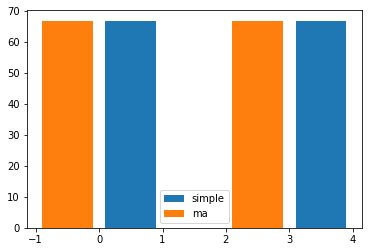

In [6]:
import matplotlib.pyplot as plt
plt.bar(np.array([0,3])+0.5,results_simple['mean_rewards'], label = 'simple')
plt.bar(np.array([0,3])-0.5,results_ma['mean_rewards'], label = 'ma')
plt.legend()
plt.show()